In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

2023-04-01 18:28:24.815096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 18:28:25.607978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ntolley/.openmpi/lib
2023-04-01 18:28:25.608107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-01 18:28:25.671805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-01 18:28:26.80

numprocs=1


In [2]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'
noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

In [3]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='position')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

# X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
# y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

# X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
# y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

# train_labels = training_set[:][2].detach().cpu().numpy()
# test_labels = testing_set[:][2].detach().cpu().numpy()

In [4]:
train_trial_lengths = [len(rateData) for rateData in training_set.neuralData_list]
X_train_array = np.vstack(training_set.neuralData_list)

test_trial_lengths = [len(rateData) for rateData in testing_set.neuralData_list]
X_test_array = np.vstack(testing_set.neuralData_list)

pca = PCA(n_components=10)
pca.fit(X_train_array)
X_test_transformed = pca.transform(X_test_array)

test_trial_labels = testing_set.trial_labels


In [5]:
pca = PCA(n_components=10)
pca.fit(X_train_array)
X_transformed = pca.transform(X_test_array)

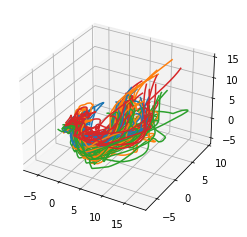

In [6]:
# %matplotlib widget
time_pos = 0
ax = plt.figure().add_subplot(projection='3d')
for trial_idx in range(len(test_trial_labels)):
    trial_length = test_trial_lengths[trial_idx]
    bounds = range(time_pos,time_pos+trial_length)
    ax.plot(X_transformed[bounds,0], X_transformed[bounds,1], X_transformed[bounds,2], color=f'C{test_trial_labels[trial_idx]-1}')
    time_pos = time_pos + trial_length

In [7]:
noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

unit_corr_array = list()
for unit_idx in range(X_train_data.shape[1]):
    unit_corr = list()
    for mrk_idx in range(y_test_data.shape[1]):
        unit_corr.append(np.abs(np.corrcoef(X_train_data[:, unit_idx], y_train_data[:, mrk_idx])[0,1]))
    unit_corr_array.append(np.array(unit_corr))

unit_corr_array = np.vstack(unit_corr_array)

sort_indices = np.argsort(np.mean(unit_corr_array, axis=1))
sorted_neuron_list = neuron_list[sort_indices]

# func_dict = {'wiener': contrastive_functions.run_wiener}
func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
# fpath = '../data/SPK20220308/neuron_num_results/'

# num_neuron_list = [2,3,4,5,10,15,20,30]
num_neurons = 3

neuron_subset = sorted_neuron_list[:num_neurons]

# Filter neural_df with task info to random subset of neurons
task_unit_mask = np.in1d(task_neural_df['unit'].values, neuron_subset)
layout_mask = task_neural_df['unit'].str.contains(pat='layout')

task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

# Filter neural_df without task info to random subset of neurons
notask_unit_mask = np.in1d(notask_neural_df['unit'].values, neuron_subset)
notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
            'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}


decode_results = dict()
model_dict = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    model_dict[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        print(f'{func_name}_{df_type} num_neurons: {num_neurons}')
        model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)

        decode_results[func_name][df_type] = res_dict
        model_dict[func_name][df_type] = model


wiener_task num_neurons: 3
wiener_notask num_neurons: 3
rnn_task num_neurons: 3
**

In [13]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df_filtered, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='position')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays

In [25]:
output, hidden, cell = model(training_set[:][0].float())

: 

: 